# Developers.IO 2018 沖縄デモ資料

## 内容について
[Developers.IO 2018 沖縄](https://dev.classmethod.jp/news/developers-io-2018-okinawa/)にて発表した、
『Amazon SageMakerでゼロからはじめる機械学習入門』のでも部分のNotebookとなります。

内容は、SageMaker公式ExampleにあるLinearLearnerを使ったmnistの二値分類を多値分類に変更するなど、一部手を加えたものになってます。

- [linear_learner_mnist.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/linear_learner_mnist/linear_learner_mnist.ipynb)

### データの保存先S3バケット、IAMロールの設定

In [35]:
bucket = 'cm-ozawa-sagemaker'
prefix = 'sagemaker/linear-mnist'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### データの取得

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 948 ms, sys: 304 ms, total: 1.25 s
Wall time: 6.57 s


### データ確認
mnistは手書き数字認識のためのデータセット
ハガキの郵便番号を自動識別して振り分けるみたいな感じ利用する

10件程度サンプルでどのようなデータかを確認
「This is a ○」となっている部分が、書かれている数字でその下の画像が実際に書かれたもの

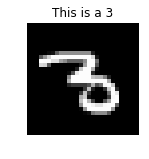

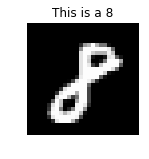

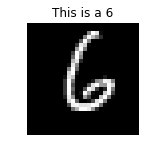

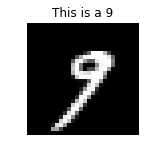

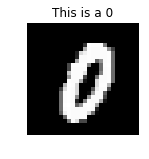

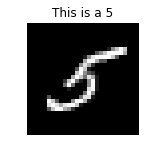

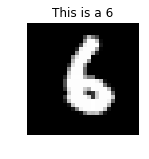

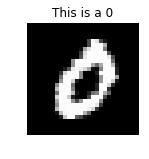

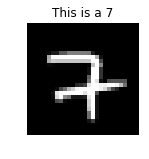

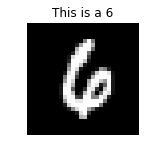

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

for i in range(30, 40):
    show_digit(train_set[0][i], 'This is a {}'.format(train_set[1][i]))

In [4]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype('float32')
labels = np.array([t.tolist() for t in train_set[1]]).astype('float32')

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

### SageMakerから利用するためにデータをS3にアップロード 

In [5]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://cm-ozawa-sagemaker/sagemaker/linear-mnist/train/recordio-pb-data


In [6]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://cm-ozawa-sagemaker/sagemaker/linear-mnist/output


### 学習に利用するコンテナ情報を取得

In [7]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

取得したコンテナ情報を利用してEstimatorのインスタンスを作成。

- train_instance_count : 学習の際に利用するインスタンス数。この値を増やす事で分散処理で学習する
- train_instance_type : 学習に利用するインスタンスタイプ

インスタンスを作成してハイパーパラメータの設定を行なったのち、
学習の処理はfit関数にデータを渡すだけで完了

In [8]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=784,
                           num_classes=10,
                           predictor_type='multiclass_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-08-28-08-52-42-205


....................
Docker entrypoint called with argument(s): train
[08/28/2018 08:55:52 INFO 140629798504256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'num_models': u'auto', u'early_stopping_patience': u'3', u'momentum': u'auto', u'unbias_label': u'auto', u'wd': u'auto', u'optimizer': u'auto', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.001', u'learning_rate': u'auto', u'_kvstore': u'auto', u'normalize_data': u'true', u'binary_cla

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.5396149308776855, "sum": 0.5396149308776855, "min": 0.5396149308776855}}, "EndTime": 1535446566.283216, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1535446566.28315}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7674524745941163, "sum": 0.7674524745941163, "min": 0.7674524745941163}}, "EndTime": 1535446566.283292, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1535446566.283279}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 1.1391039805984498, "sum": 1.1391039805984498, "min": 1.1391039805984498}}, "EndTime": 1535446566.283353, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 0}, "StartTime": 1535

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.4309115242767334, "sum": 0.4309115242767334, "min": 0.4309115242767334}}, "EndTime": 1535446578.804766, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1535446578.804703}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7338382609558105, "sum": 0.7338382609558105, "min": 0.7338382609558105}}, "EndTime": 1535446578.804843, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1535446578.804831}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.9150914598846436, "sum": 0.9150914598846436, "min": 0.9150914598846436}}, "EndTime": 1535446578.804907, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 153

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.37993763580322265, "sum": 0.37993763580322265, "min": 0.37993763580322265}}, "EndTime": 1535446591.190362, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1535446591.190277}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7287684996032715, "sum": 0.7287684996032715, "min": 0.7287684996032715}}, "EndTime": 1535446591.190459, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1535446591.190443}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.776153952255249, "sum": 0.776153952255249, "min": 0.776153952255249}}, "EndTime": 1535446591.190512, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 153

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3560838391494751, "sum": 0.3560838391494751, "min": 0.3560838391494751}}, "EndTime": 1535446603.308197, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1535446603.30814}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7264887672424316, "sum": 0.7264887672424316, "min": 0.7264887672424316}}, "EndTime": 1535446603.308272, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1535446603.308259}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6775632141113281, "sum": 0.6775632141113281, "min": 0.6775632141113281}}, "EndTime": 1535446603.30839, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 15354

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.33606826168060305, "sum": 0.33606826168060305, "min": 0.33606826168060305}}, "EndTime": 1535446615.265869, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1535446615.265813}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7139554371643066, "sum": 0.7139554371643066, "min": 0.7139554371643066}}, "EndTime": 1535446615.26595, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1535446615.265932}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.5733730401992798, "sum": 0.5733730401992798, "min": 0.5733730401992798}}, "EndTime": 1535446615.266018, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3241478885269165, "sum": 0.3241478885269165, "min": 0.3241478885269165}}, "EndTime": 1535446627.114599, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1535446627.114541}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.7090592592620849, "sum": 0.7090592592620849, "min": 0.7090592592620849}}, "EndTime": 1535446627.114669, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1535446627.114656}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.5060271521759033, "sum": 0.5060271521759033, "min": 0.5060271521759033}}, "EndTime": 1535446627.114729, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 153

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31602276100158694, "sum": 0.31602276100158694, "min": 0.31602276100158694}}, "EndTime": 1535446639.047387, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1535446639.047325}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.702421734161377, "sum": 0.702421734161377, "min": 0.702421734161377}}, "EndTime": 1535446639.047499, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1535446639.04748}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.45252359619140625, "sum": 0.45252359619140625, "min": 0.45252359619140625}}, "EndTime": 1535446639.047618, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3114517826461792, "sum": 0.3114517826461792, "min": 0.3114517826461792}}, "EndTime": 1535446650.981985, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1535446650.981889}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6949849349975586, "sum": 0.6949849349975586, "min": 0.6949849349975586}}, "EndTime": 1535446650.982082, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1535446650.982064}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.40920135147094727, "sum": 0.40920135147094727, "min": 0.40920135147094727}}, "EndTime": 1535446650.982149, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3083613935089111, "sum": 0.3083613935089111, "min": 0.3083613935089111}}, "EndTime": 1535446662.701346, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1535446662.701289}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6858022427368164, "sum": 0.6858022427368164, "min": 0.6858022427368164}}, "EndTime": 1535446662.701428, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1535446662.70141}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3781503999710083, "sum": 0.3781503999710083, "min": 0.3781503999710083}}, "EndTime": 1535446662.701492, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1535

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3064842211532593, "sum": 0.3064842211532593, "min": 0.3064842211532593}}, "EndTime": 1535446674.419102, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1535446674.419044}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6770312535858154, "sum": 0.6770312535858154, "min": 0.6770312535858154}}, "EndTime": 1535446674.419174, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1535446674.419161}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3521927733230591, "sum": 0.3521927733230591, "min": 0.3521927733230591}}, "EndTime": 1535446674.419239, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 153

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.30509841793060305, "sum": 0.30509841793060305, "min": 0.30509841793060305}}, "EndTime": 1535446686.13772, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1535446686.137661}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6720582006072998, "sum": 0.6720582006072998, "min": 0.6720582006072998}}, "EndTime": 1535446686.137802, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1535446686.137783}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.33172984119415283, "sum": 0.33172984119415283, "min": 0.33172984119415283}}, "EndTime": 1535446686.137867, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTi

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3042155330657959, "sum": 0.3042155330657959, "min": 0.3042155330657959}}, "EndTime": 1535446697.742894, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1535446697.742811}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6662037152099609, "sum": 0.6662037152099609, "min": 0.6662037152099609}}, "EndTime": 1535446697.742988, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime": 1535446697.742971}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.31777049587249756, "sum": 0.31777049587249756, "min": 0.31777049587249756}}, "EndTime": 1535446697.743038, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 11}, "StartTime

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.30365695846557617, "sum": 0.30365695846557617, "min": 0.30365695846557617}}, "EndTime": 1535446709.281037, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1535446709.280976}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6572060129547119, "sum": 0.6572060129547119, "min": 0.6572060129547119}}, "EndTime": 1535446709.281121, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartTime": 1535446709.281103}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.30493151149749753, "sum": 0.30493151149749753, "min": 0.30493151149749753}}, "EndTime": 1535446709.281186, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 12}, "StartT

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.30330841815948484, "sum": 0.30330841815948484, "min": 0.30330841815948484}}, "EndTime": 1535446720.79602, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1535446720.795965}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6535582007598877, "sum": 0.6535582007598877, "min": 0.6535582007598877}}, "EndTime": 1535446720.796113, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1535446720.796095}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.29511352684020997, "sum": 0.29511352684020997, "min": 0.29511352684020997}}, "EndTime": 1535446720.796172, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTi

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.3030932395172119, "sum": 0.3030932395172119, "min": 0.3030932395172119}}, "EndTime": 1535446732.223507, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1535446732.22345}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.6473778115844726, "sum": 0.6473778115844726, "min": 0.6473778115844726}}, "EndTime": 1535446732.223589, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 1535446732.22357}

#metrics {"Metrics": {"train_multiclass_cross_entropy_objective": {"count": 1, "max": 0.2872787644577026, "sum": 0.2872787644577026, "min": 0.2872787644577026}}, "EndTime": 1535446732.223647, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 14}, "StartTime": 15


Billable seconds: 277


### エンドポイントをデプロイする
機械学習の推論部分を他のシステムから利用可能にするために、APIのエンドポイントを作成する
インスタンス数はスケールさせることも可能

In [18]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-08-28-09-05-28-995
INFO:sagemaker:Creating endpoint with name linear-learner-2018-08-28-08-52-42-205


---------------------------------------------------------------!

### 推論結果の確認

In [19]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

In [20]:
result = linear_predictor.predict(train_set[0][30:40])
print(result)

{'predictions': [{'score': [1.000000013351432e-10, 7.719649147475138e-05, 0.0002310206909896806, 0.9992199540138245, 2.431235770927742e-06, 3.6111225199420005e-05, 3.700147033214307e-07, 0.00016467626846861094, 0.00026737042935565114, 8.829578632685298e-07], 'predicted_label': 3.0}, {'score': [8.360558240383398e-06, 0.0032584096770733595, 0.0052949064411222935, 0.04515336826443672, 2.639563012607482e-09, 1.1285499567748047e-05, 1.4568081851962233e-08, 2.7929027623940783e-07, 0.9396771192550659, 0.00659623509272933], 'predicted_label': 8.0}, {'score': [7.26649523130618e-05, 5.639234927912185e-07, 0.0012848575133830309, 1.1882563740073238e-05, 4.5021002733847126e-05, 0.008132437244057655, 0.9903256297111511, 1.8654446876098518e-07, 0.00011082788114435971, 1.5969071682775393e-05], 'predicted_label': 6.0}, {'score': [1.5812645415280713e-08, 1.878139482869301e-05, 3.656753335690155e-07, 0.0074031297117471695, 6.629252311540768e-05, 2.911525371018797e-05, 6.314980205424092e-10, 0.46638396382

データの確認時と同じ方法で推論結果を確認。
先ほどと違うのは「This is a ○」の表示が正解ではなく機械学習で予測した値を出力している部分

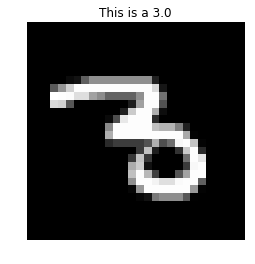

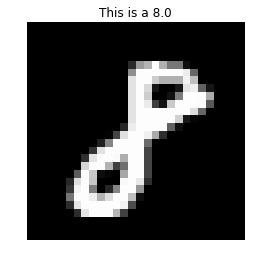

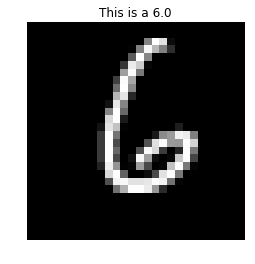

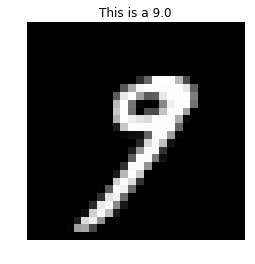

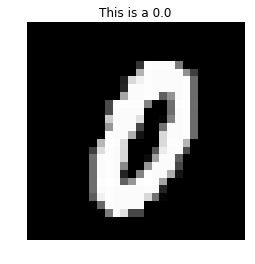

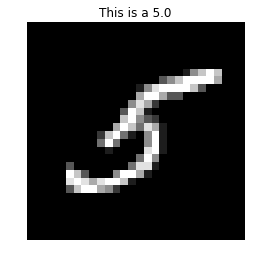

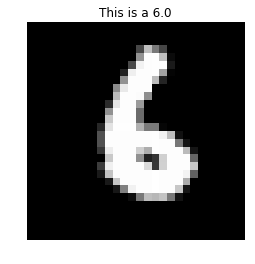

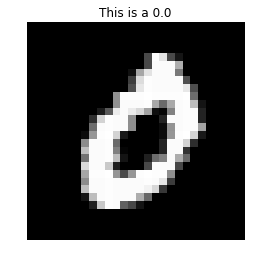

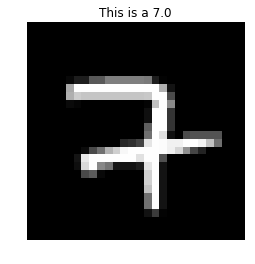

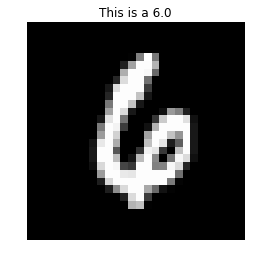

In [31]:
for i, j in zip(range(30, 40), result['predictions']):
    show_digit(train_set[0][i], 'This is a {}'.format(j['predicted_label']))

どのくらい正解できているかの確認

表は横が「予測したの値」、縦が「正解の値」
同じ値がクロスしている部分が予測結果が正しかったものなので、対角成分の数値が多いほどいい結果

In [32]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [33]:
import pandas as pd

pd.crosstab(test_set[1], predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
actuals,,,,,,,,,,
0,957,0,0,2,1,9,6,3,2,0
1,0,1111,3,2,0,1,4,2,12,0
2,5,7,925,20,7,6,12,9,40,1
3,3,1,16,921,0,23,1,14,24,7
4,1,3,10,1,918,0,9,5,8,27
5,8,3,3,39,7,778,14,7,29,4
6,10,3,6,4,7,19,904,1,4,0
7,0,8,21,9,4,1,0,949,3,33
8,6,7,7,25,9,24,7,8,871,10


いくつかの値で予測値と正解値を並べてみる

In [34]:
predict_result = pd.DataFrame({'actual' : test_set[1], 'prediction' : predictions})
predict_result.head()

,actual,prediction
0,7,7.0
1,2,2.0
2,1,1.0
3,0,0.0
4,4,4.0


正解率は92.44%

In [16]:
sum(predict_result.apply(lambda row : row['actual'] == row['prediction'], axis=1)) / len(test_set[1])

0.9244

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [36]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: linear-learner-2018-08-28-08-52-42-205
